# 02 — Exploratory Data Analysis (EDA)
**The Safe Lending Project**

This notebook answers the core questions from the PDF analysis:
1. Does grade accurately predict default?
2. Has grade reliability drifted over time?
3. Is interest rate aligned with risk within each grade?
4. Do borrowers with similar credit profiles default differently by debt/income/employment?
5. Do same-grade loans perform differently across states?
6. Do joint vs. individual applications behave differently?
7. What credit/account patterns predict default?

**Prerequisite:** Run `01_data_cleaning.ipynb` first to generate `master_full.csv`

In [2]:
# ── Imports & Config ──
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings, os

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 80)
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set_style('whitegrid')
sns.set_palette('Set2')

CHARTS_DIR = os.path.join('..', 'charts')
os.makedirs(CHARTS_DIR, exist_ok=True)

# Load only needed columns to avoid out-of-memory parsing
DATA_DIR = os.path.join('..', 'data')
REQUIRED_COLS = {
    'loan_status', 'is_default', 'grade', 'sub_grade', 'int_rate', 'installment',
    'issue_year', 'annual_inc', 'emp_length_yrs', 'home_ownership', 'purpose',
    'dti', 'addr_state', 'application_type', 'revol_util', 'delinq_2yrs',
    'open_acc', 'inq_last_6mths', 'loan_amnt', 'term', 'verification_status',
    'revol_bal', 'total_acc', 'pub_rec', 'tot_cur_bal', 'total_rev_hi_lim',
    'recoveries', 'hardship_flag', 'debt_settlement_flag'
}

df = pd.read_csv(
    os.path.join(DATA_DIR, 'master_full.csv'),
    usecols=lambda c: c in REQUIRED_COLS,
    low_memory=True
)

print(f"✅ Loaded memory-safe dataset: {df.shape[0]:,} rows × {df.shape[1]} cols")
print(f"Columns loaded: {list(df.columns)}")

✅ Loaded memory-safe dataset: 2,260,668 rows × 29 cols
Columns loaded: ['term', 'installment', 'grade', 'loan_status', 'application_type', 'purpose', 'tot_cur_bal', 'total_rev_hi_lim', 'loan_amnt', 'int_rate', 'sub_grade', 'home_ownership', 'annual_inc', 'verification_status', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'recoveries', 'hardship_flag', 'debt_settlement_flag', 'is_default', 'emp_length_yrs', 'issue_year']


## 1. Loan Status Distribution
> Q: What is the overall distribution of loan outcomes?

loan_status
Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: count, dtype: int64

Total loans: 2,260,668


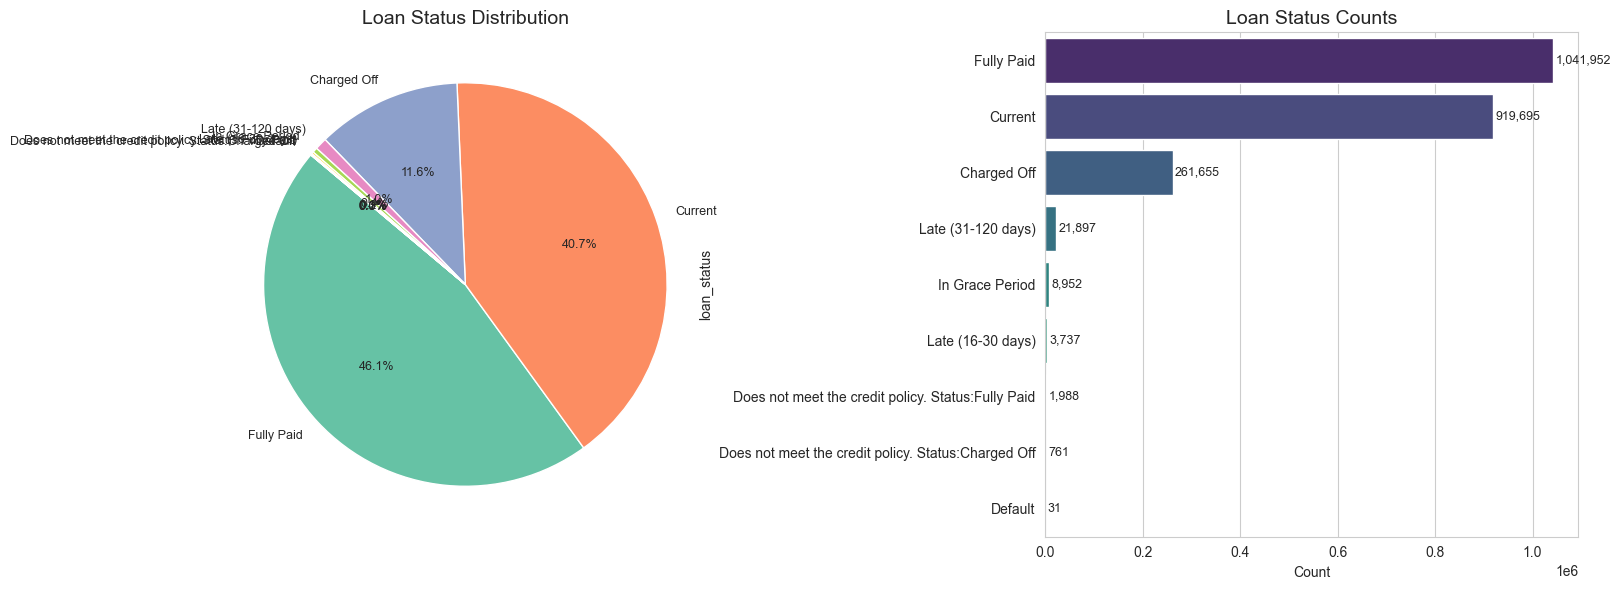

In [3]:
# ── 1. Loan Status Distribution ──
status_counts = df['loan_status'].value_counts()
print(status_counts)
print(f"\nTotal loans: {len(df):,}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart
axes[0].pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%',
            startangle=140, textprops={'fontsize': 9})
axes[0].set_title('Loan Status Distribution', fontsize=14)

# Bar chart
sns.barplot(x=status_counts.values, y=status_counts.index, ax=axes[1], palette='viridis')
axes[1].set_xlabel('Count')
axes[1].set_title('Loan Status Counts', fontsize=14)
for i, v in enumerate(status_counts.values):
    axes[1].text(v + 5000, i, f'{v:,}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(f'{CHARTS_DIR}/01_loan_status_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. Default Rate by Grade
> Q: Does grade accurately predict default? (PDF question)

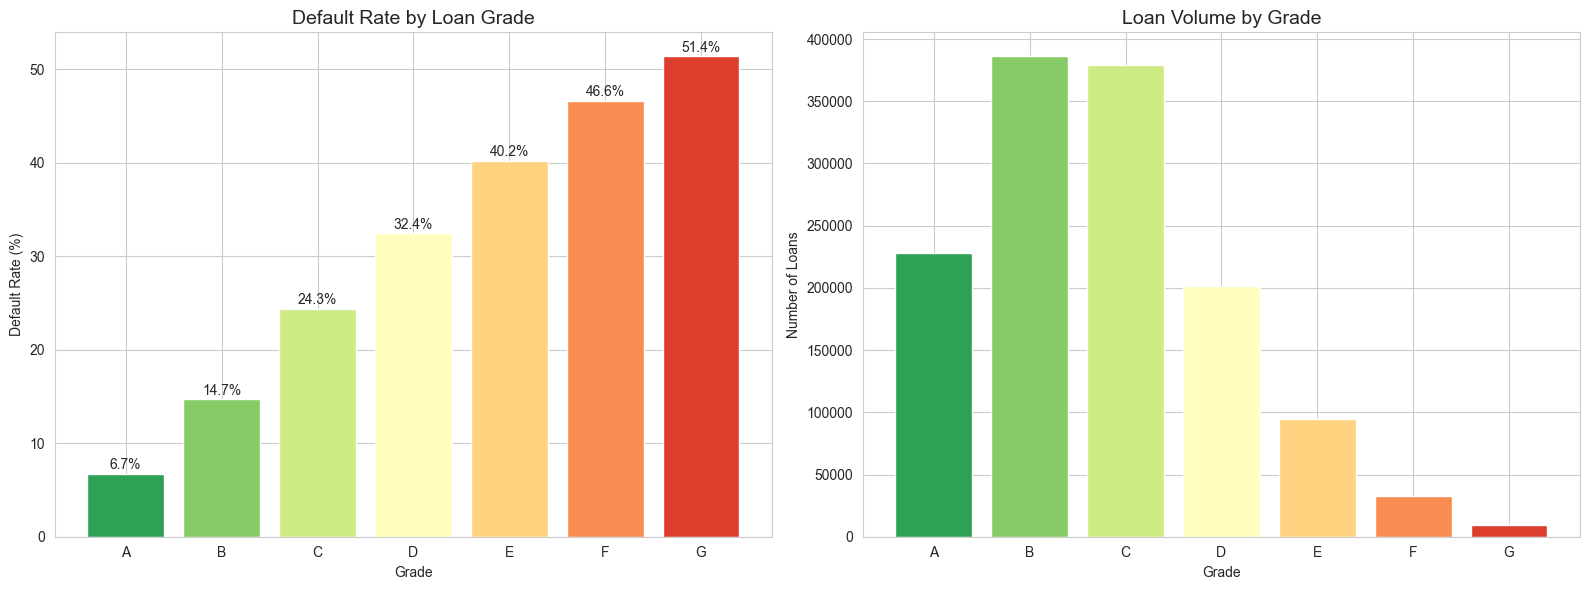

📊 Key insight: Default rate should increase A→G. Any anomaly = grade drift.


In [4]:
# ── 2. Default Rate by Grade ──
terminal = df[df['is_default'].notna()].copy()
terminal['is_default'] = terminal['is_default'].astype(int)

grade_default = terminal.groupby('grade')['is_default'].agg(['mean', 'count']).reset_index()
grade_default.columns = ['grade', 'default_rate', 'count']
grade_default = grade_default.sort_values('grade')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Default rate by grade
colors = sns.color_palette('RdYlGn_r', len(grade_default))
axes[0].bar(grade_default['grade'], grade_default['default_rate'] * 100, color=colors)
axes[0].set_xlabel('Grade')
axes[0].set_ylabel('Default Rate (%)')
axes[0].set_title('Default Rate by Loan Grade', fontsize=14)
for i, row in grade_default.iterrows():
    axes[0].text(row['grade'], row['default_rate'] * 100 + 0.5, 
                 f"{row['default_rate']*100:.1f}%", ha='center', fontsize=10)

# Loan count by grade
axes[1].bar(grade_default['grade'], grade_default['count'], color=colors)
axes[1].set_xlabel('Grade')
axes[1].set_ylabel('Number of Loans')
axes[1].set_title('Loan Volume by Grade', fontsize=14)

plt.tight_layout()
plt.savefig(f'{CHARTS_DIR}/02_default_rate_by_grade.png', dpi=150, bbox_inches='tight')
plt.show()

print("📊 Key insight: Default rate should increase A→G. Any anomaly = grade drift.")

## 3. Default Rate by Sub-Grade & Interest Rate vs Grade
> Q: Is interest rate aligned with risk within each grade?

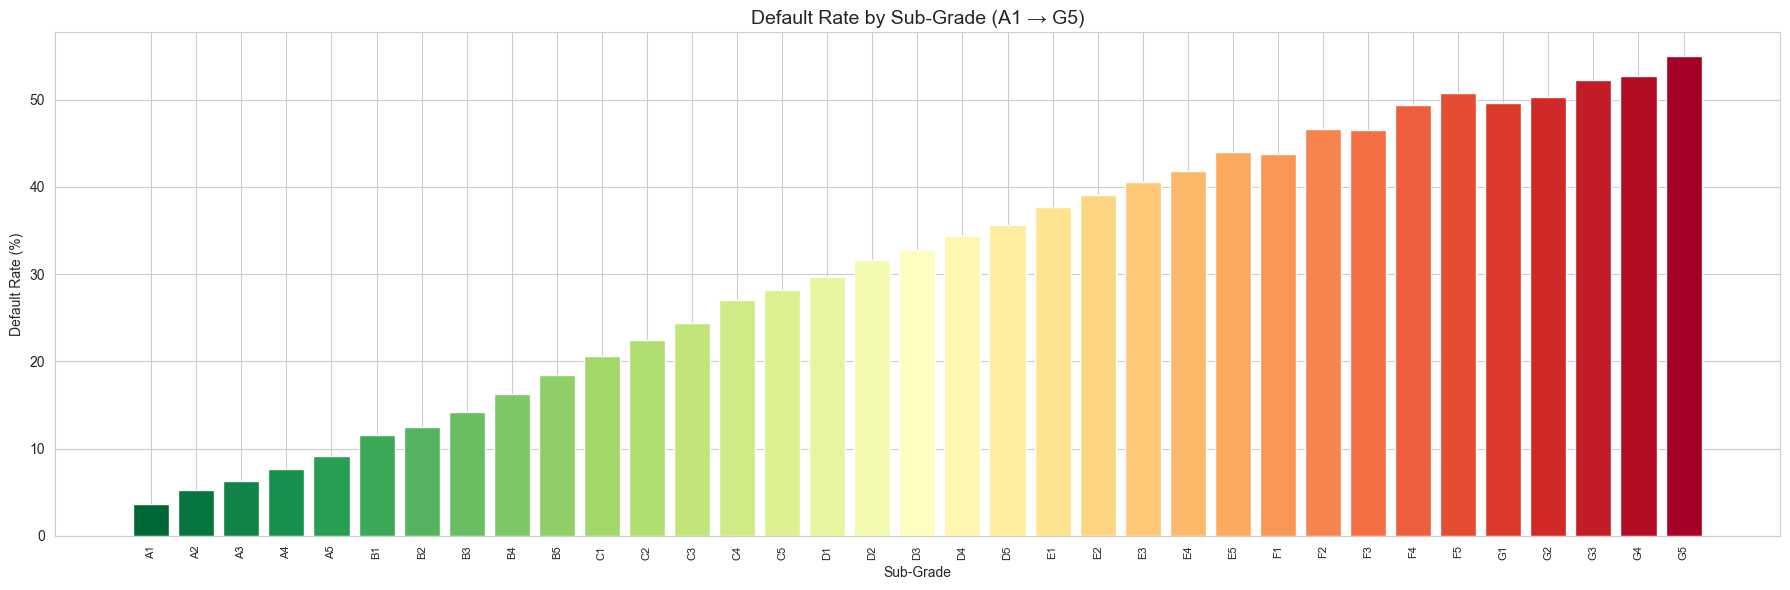

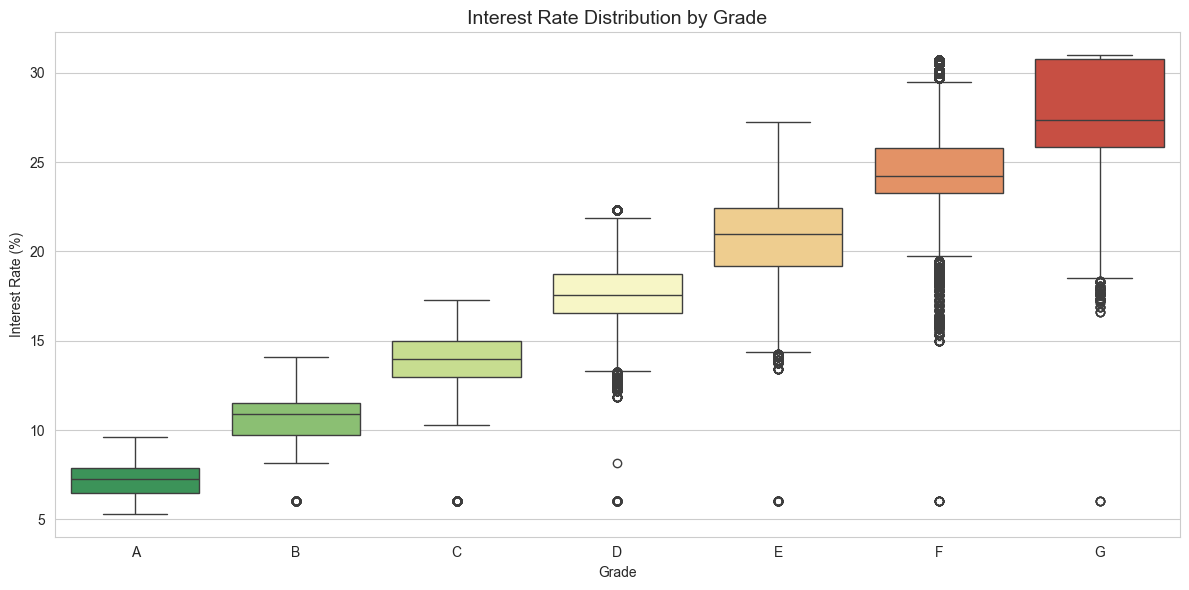

In [5]:
# ── 3a. Default Rate by Sub-Grade ──
if 'sub_grade' in terminal.columns:
    sg_default = terminal.groupby('sub_grade')['is_default'].mean().reset_index()
    sg_default.columns = ['sub_grade', 'default_rate']
    sg_default = sg_default.sort_values('sub_grade')
    
    fig, ax = plt.subplots(figsize=(18, 6))
    colors = plt.cm.RdYlGn_r(np.linspace(0, 1, len(sg_default)))
    ax.bar(sg_default['sub_grade'], sg_default['default_rate'] * 100, color=colors)
    ax.set_xlabel('Sub-Grade')
    ax.set_ylabel('Default Rate (%)')
    ax.set_title('Default Rate by Sub-Grade (A1 → G5)', fontsize=14)
    ax.tick_params(axis='x', rotation=90, labelsize=8)
    plt.tight_layout()
    plt.savefig(f'{CHARTS_DIR}/03_default_rate_by_subgrade.png', dpi=150, bbox_inches='tight')
    plt.show()

# ── 3b. Interest Rate Distribution by Grade ──
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=terminal, x='grade', y='int_rate', order=sorted(terminal['grade'].unique()), ax=ax, palette='RdYlGn_r')
ax.set_xlabel('Grade')
ax.set_ylabel('Interest Rate (%)')
ax.set_title('Interest Rate Distribution by Grade', fontsize=14)
plt.tight_layout()
plt.savefig(f'{CHARTS_DIR}/04_interest_rate_by_grade.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Grade Reliability Over Time (Temporal Drift)
> Q: Has grade reliability drifted over time? (PDF core concern)

In [6]:
# ── 4. Default Rate by Grade Over Time ──
if 'issue_year' in terminal.columns:
    grade_year = terminal.groupby(['issue_year', 'grade'])['is_default'].mean().reset_index()
    grade_year.columns = ['year', 'grade', 'default_rate']
    
    fig = px.line(grade_year, x='year', y='default_rate', color='grade',
                  title='Default Rate by Grade Over Time (Temporal Drift Analysis)',
                  labels={'default_rate': 'Default Rate', 'year': 'Issue Year'},
                  markers=True)
    fig.update_layout(yaxis_tickformat='.1%', width=1000, height=500)
    try:
        fig.write_image(f'{CHARTS_DIR}/05_grade_drift_over_time.png', scale=2)
    except Exception as image_error:
        print(f"Image export skipped: {image_error}")
    fig.show()
    
    print("📊 If lines cross or converge, it indicates grade meaning is shifting over time.")

📊 If lines cross or converge, it indicates grade meaning is shifting over time.


## 5. Borrower Profile: Income, Employment, Home Ownership
> Q: Higher income ≠ lower default? Employment length effect? (PDF questions)

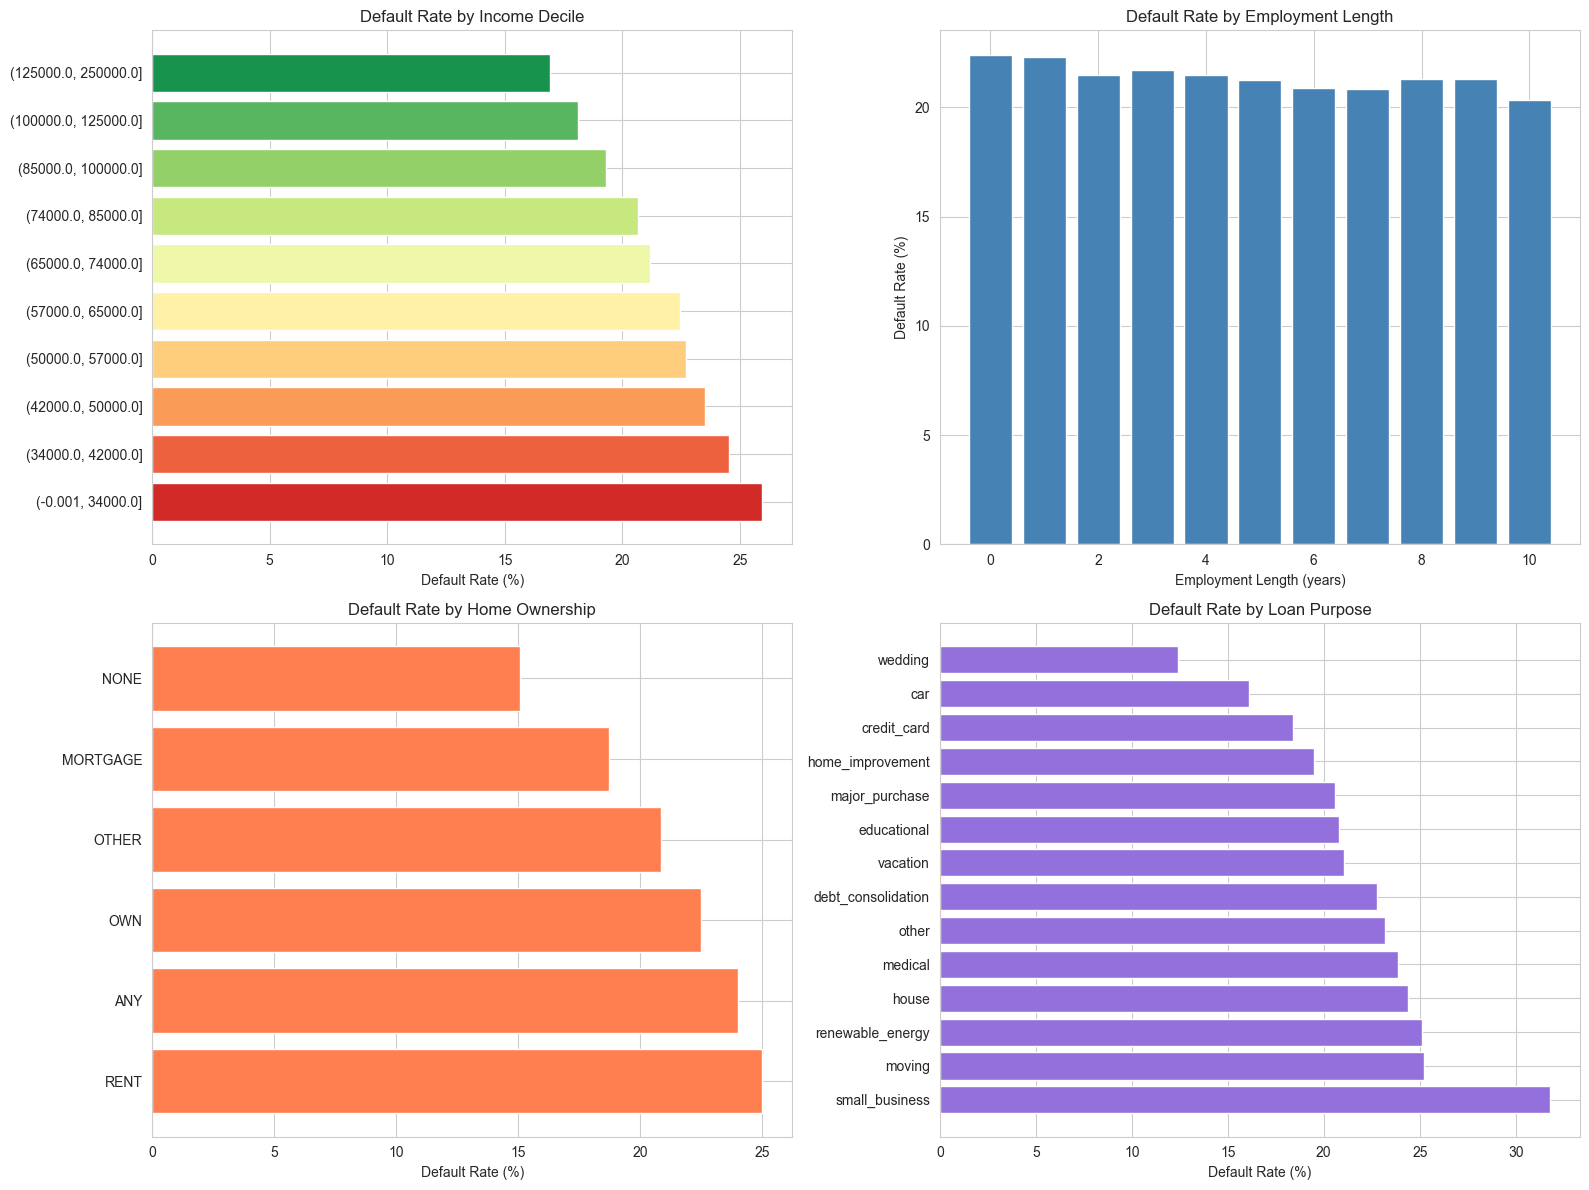

📊 PDF insight: Some higher-income applicants default unexpectedly, moderate profiles repay consistently.


In [7]:
# ── 5a. Default Rate by Annual Income Quantiles ──
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Income quantiles
terminal['inc_bin'] = pd.qcut(terminal['annual_inc'].clip(upper=terminal['annual_inc'].quantile(0.99)), 
                               q=10, duplicates='drop')
inc_default = terminal.groupby('inc_bin', observed=True)['is_default'].mean().reset_index()
axes[0, 0].barh(inc_default['inc_bin'].astype(str), inc_default['is_default'] * 100, color=sns.color_palette('RdYlGn', len(inc_default)))
axes[0, 0].set_xlabel('Default Rate (%)')
axes[0, 0].set_title('Default Rate by Income Decile', fontsize=12)

# Employment length
if 'emp_length_yrs' in terminal.columns:
    emp_default = terminal.groupby('emp_length_yrs')['is_default'].mean().reset_index()
    emp_default = emp_default.dropna()
    axes[0, 1].bar(emp_default['emp_length_yrs'], emp_default['is_default'] * 100, color='steelblue')
    axes[0, 1].set_xlabel('Employment Length (years)')
    axes[0, 1].set_ylabel('Default Rate (%)')
    axes[0, 1].set_title('Default Rate by Employment Length', fontsize=12)

# Home ownership
if 'home_ownership' in terminal.columns:
    ho_default = terminal.groupby('home_ownership')['is_default'].mean().sort_values(ascending=False).reset_index()
    axes[1, 0].barh(ho_default['home_ownership'], ho_default['is_default'] * 100, color='coral')
    axes[1, 0].set_xlabel('Default Rate (%)')
    axes[1, 0].set_title('Default Rate by Home Ownership', fontsize=12)

# Loan purpose
purpose_default = terminal.groupby('purpose')['is_default'].mean().sort_values(ascending=False).reset_index()
axes[1, 1].barh(purpose_default['purpose'], purpose_default['is_default'] * 100, color='mediumpurple')
axes[1, 1].set_xlabel('Default Rate (%)')
axes[1, 1].set_title('Default Rate by Loan Purpose', fontsize=12)

plt.tight_layout()
plt.savefig(f'{CHARTS_DIR}/06_borrower_profile_default.png', dpi=150, bbox_inches='tight')
plt.show()

print("📊 PDF insight: Some higher-income applicants default unexpectedly, moderate profiles repay consistently.")

## 6. DTI Analysis — Debt Segments vs Default
> Q: Do borrowers with similar credit scores default differently by debt level?

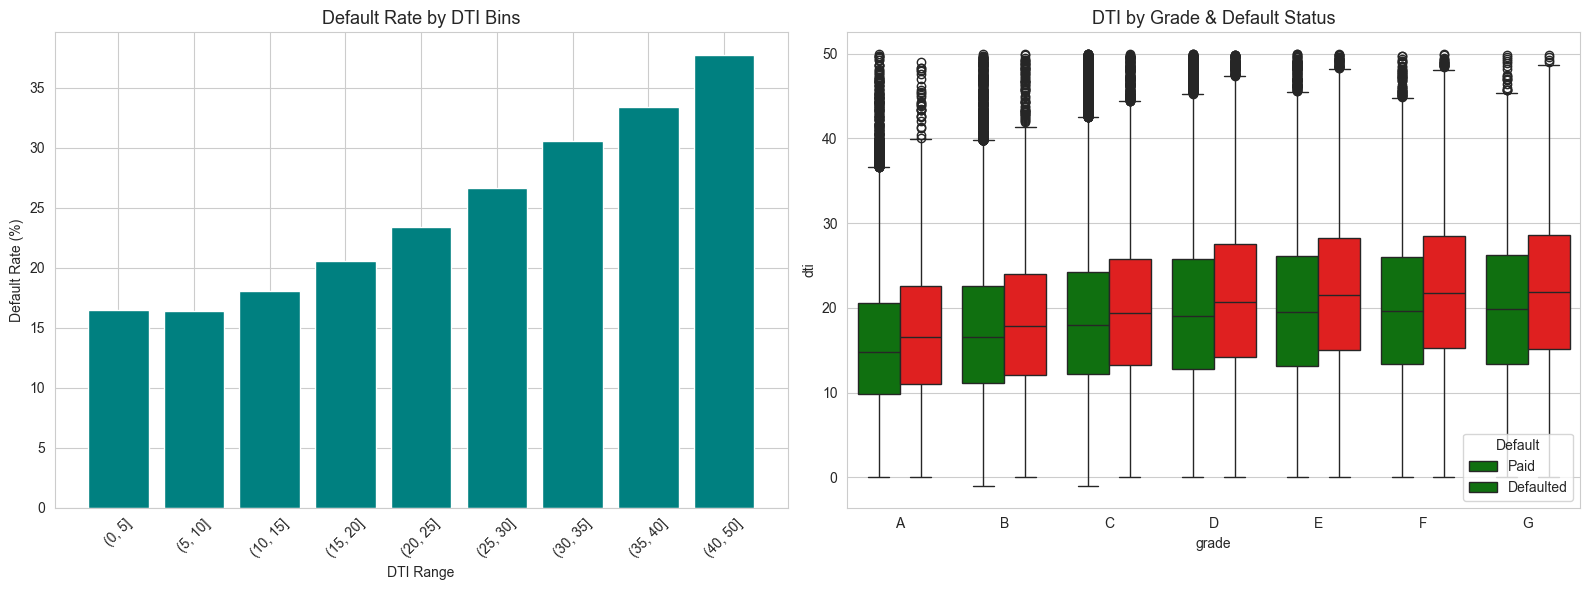

In [8]:
# ── 6. DTI vs Default, by Grade ──
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 6a. Default rate by DTI bins
terminal['dti_bin'] = pd.cut(terminal['dti'].clip(upper=50), bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 50])
dti_default = terminal.groupby('dti_bin', observed=True)['is_default'].mean().reset_index()
axes[0].bar(dti_default['dti_bin'].astype(str), dti_default['is_default'] * 100, color='teal')
axes[0].set_xlabel('DTI Range')
axes[0].set_ylabel('Default Rate (%)')
axes[0].set_title('Default Rate by DTI Bins', fontsize=13)
axes[0].tick_params(axis='x', rotation=45)

# 6b. DTI distribution by default status (box plot)
sns.boxplot(data=terminal[terminal['dti'] < 50], x='grade', y='dti', hue='is_default',
            order=sorted(terminal['grade'].unique()), ax=axes[1], palette={0: 'green', 1: 'red'})
axes[1].set_title('DTI by Grade & Default Status', fontsize=13)
axes[1].legend(title='Default', labels=['Paid', 'Defaulted'])

plt.tight_layout()
plt.savefig(f'{CHARTS_DIR}/07_dti_vs_default.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Geographic Variation — State-Level Default Rates
> Q: Do same-grade loans perform differently across states? (PDF concern)

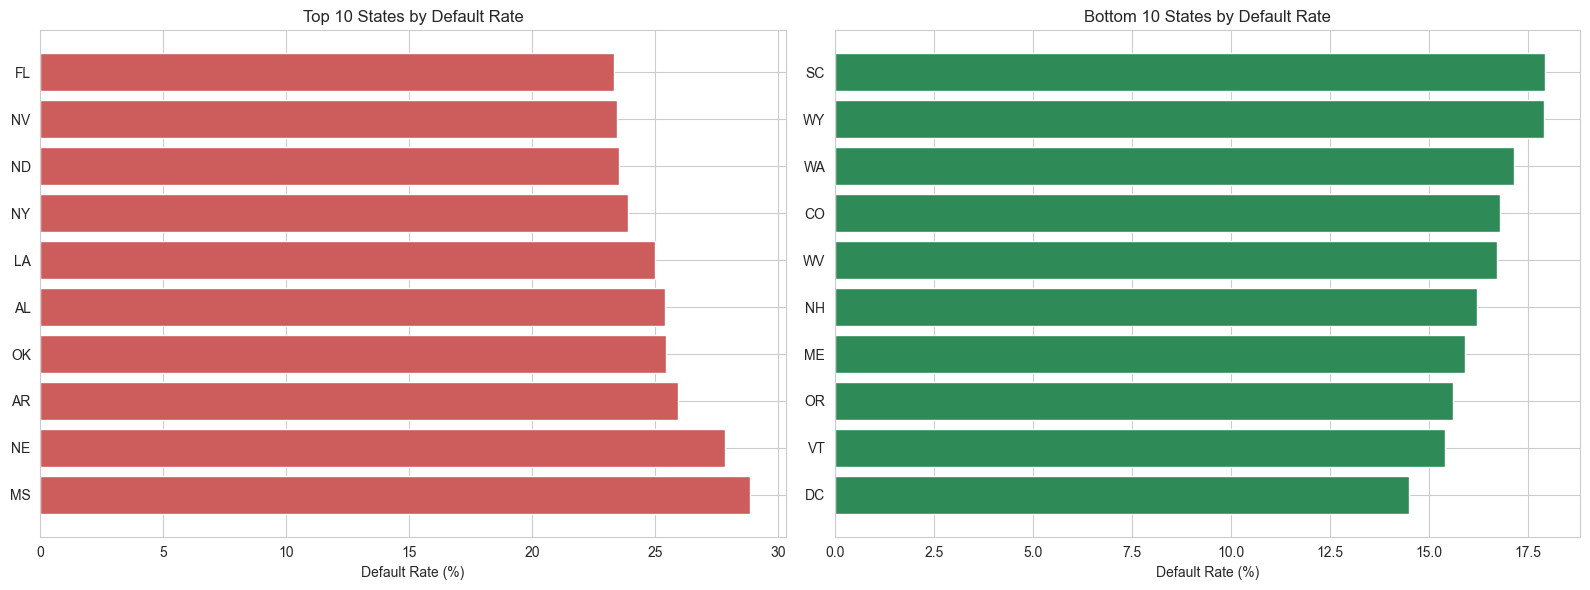

In [9]:
# ── 7. Geographic Analysis: Default Rate by State ──
if 'addr_state' in terminal.columns:
    state_default = terminal.groupby('addr_state')['is_default'].agg(['mean', 'count']).reset_index()
    state_default.columns = ['state', 'default_rate', 'loan_count']
    state_default = state_default[state_default['loan_count'] >= 100]  # filter low-volume states
    
    # Choropleth map
    fig = px.choropleth(state_default, locations='state', locationmode='USA-states',
                        color='default_rate', scope='usa',
                        color_continuous_scale='RdYlGn_r',
                        title='Default Rate by State (Choropleth)',
                        labels={'default_rate': 'Default Rate'})
    fig.update_layout(width=1000, height=600)
    try:
        fig.write_image(f'{CHARTS_DIR}/08_default_rate_by_state_map.png', scale=2)
    except Exception as image_error:
        print(f"Image export skipped: {image_error}")
    fig.show()
    
    # Top/Bottom 10 states
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    top10 = state_default.nlargest(10, 'default_rate')
    bot10 = state_default.nsmallest(10, 'default_rate')
    
    axes[0].barh(top10['state'], top10['default_rate'] * 100, color='indianred')
    axes[0].set_title('Top 10 States by Default Rate', fontsize=12)
    axes[0].set_xlabel('Default Rate (%)')
    
    axes[1].barh(bot10['state'], bot10['default_rate'] * 100, color='seagreen')
    axes[1].set_title('Bottom 10 States by Default Rate', fontsize=12)
    axes[1].set_xlabel('Default Rate (%)')
    
    plt.tight_layout()
    plt.savefig(f'{CHARTS_DIR}/09_top_bottom_states.png', dpi=150, bbox_inches='tight')
    plt.show()

## 8. Joint vs. Individual Applications
> Q: Joint applications did not behave the same as individual ones — even with strong combined financials (PDF)

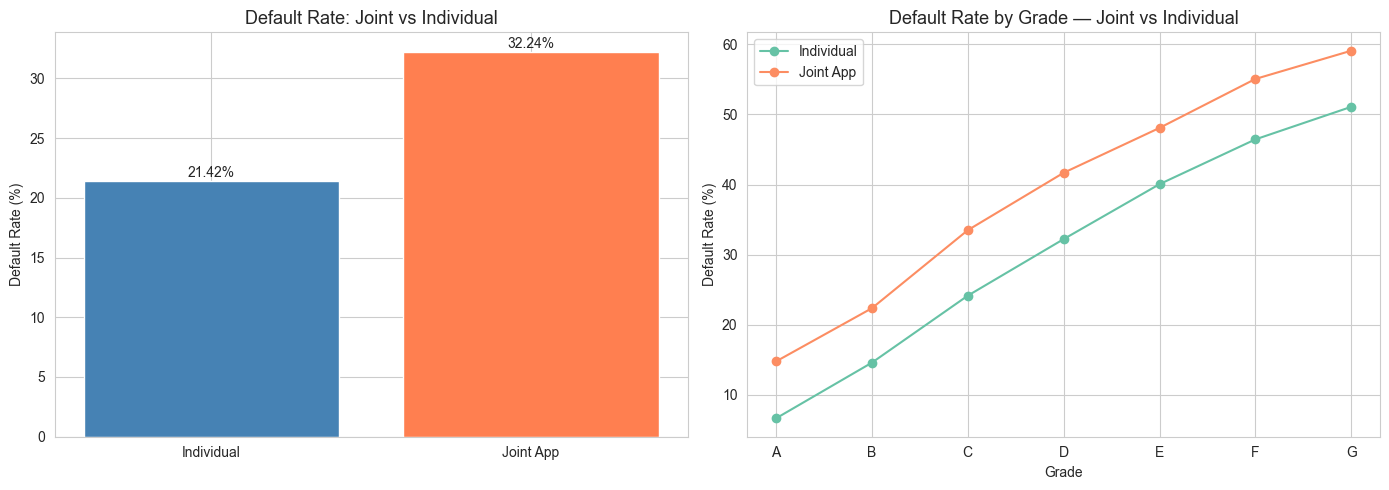

application_type  default_rate   count
      Individual          0.21 1306182
       Joint App          0.32   25839


In [10]:
# ── 8. Joint vs Individual Applications ──
if 'application_type' in terminal.columns:
    app_default = terminal.groupby('application_type')['is_default'].agg(['mean', 'count']).reset_index()
    app_default.columns = ['application_type', 'default_rate', 'count']
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].bar(app_default['application_type'], app_default['default_rate'] * 100, 
                color=['steelblue', 'coral'])
    axes[0].set_ylabel('Default Rate (%)')
    axes[0].set_title('Default Rate: Joint vs Individual', fontsize=13)
    for i, row in app_default.iterrows():
        axes[0].text(i, row['default_rate'] * 100 + 0.3, f"{row['default_rate']*100:.2f}%", ha='center')
    
    # By grade within app type
    app_grade = terminal.groupby(['application_type', 'grade'])['is_default'].mean().reset_index()
    for app_type in app_grade['application_type'].unique():
        subset = app_grade[app_grade['application_type'] == app_type].sort_values('grade')
        axes[1].plot(subset['grade'], subset['is_default'] * 100, marker='o', label=app_type)
    axes[1].set_xlabel('Grade')
    axes[1].set_ylabel('Default Rate (%)')
    axes[1].set_title('Default Rate by Grade — Joint vs Individual', fontsize=13)
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig(f'{CHARTS_DIR}/10_joint_vs_individual.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(app_default.to_string(index=False))

## 9. Credit & Utilization Patterns
> Q: Do delinquency history and revolving utilization predict default?

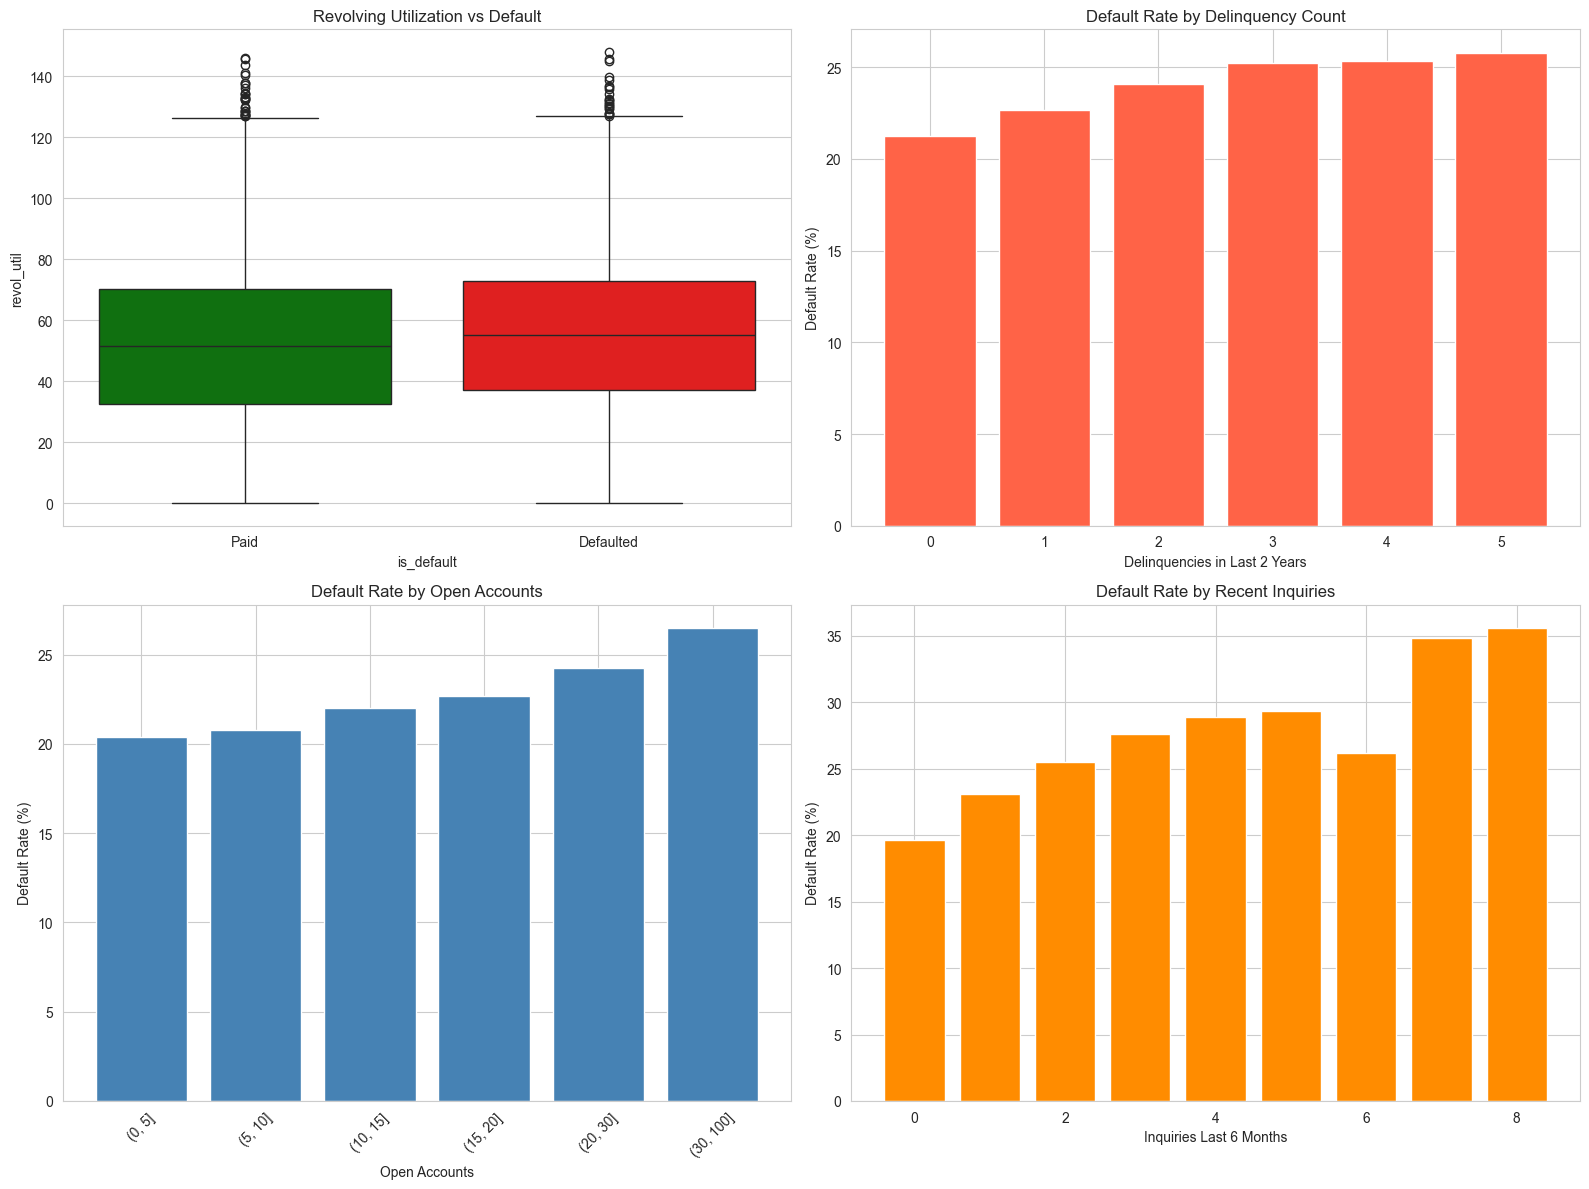

In [15]:
# ── 9. Credit & Utilization Patterns ──
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 9a. Revolving utilization vs default
if 'revol_util' in terminal.columns:
    temp_util = terminal[terminal['revol_util'] <= 150].copy()
    temp_util['is_default'] = temp_util['is_default'].astype(str)
    sns.boxplot(data=temp_util, x='is_default', y='revol_util',
                ax=axes[0, 0], palette=['green', 'red'])
    axes[0, 0].set_xticklabels(['Paid', 'Defaulted'])
    axes[0, 0].set_title('Revolving Utilization vs Default', fontsize=12)

# 9b. Delinquency (delinq_2yrs) vs default
if 'delinq_2yrs' in terminal.columns:
    delinq_def = terminal.groupby(terminal['delinq_2yrs'].clip(upper=5))['is_default'].mean().reset_index()
    axes[0, 1].bar(delinq_def['delinq_2yrs'], delinq_def['is_default'] * 100, color='tomato')
    axes[0, 1].set_xlabel('Delinquencies in Last 2 Years')
    axes[0, 1].set_ylabel('Default Rate (%)')
    axes[0, 1].set_title('Default Rate by Delinquency Count', fontsize=12)

# 9c. Open accounts vs default
if 'open_acc' in terminal.columns:
    terminal['open_acc_bin'] = pd.cut(terminal['open_acc'], bins=[0, 5, 10, 15, 20, 30, 100])
    oa_def = terminal.groupby('open_acc_bin', observed=True)['is_default'].mean().reset_index()
    axes[1, 0].bar(oa_def['open_acc_bin'].astype(str), oa_def['is_default'] * 100, color='steelblue')
    axes[1, 0].set_xlabel('Open Accounts')
    axes[1, 0].set_ylabel('Default Rate (%)')
    axes[1, 0].set_title('Default Rate by Open Accounts', fontsize=12)
    axes[1, 0].tick_params(axis='x', rotation=45)

# 9d. Inquiries (last 6 months) vs default
if 'inq_last_6mths' in terminal.columns:
    inq_def = terminal.groupby(terminal['inq_last_6mths'].clip(upper=8))['is_default'].mean().reset_index()
    axes[1, 1].bar(inq_def['inq_last_6mths'], inq_def['is_default'] * 100, color='darkorange')
    axes[1, 1].set_xlabel('Inquiries Last 6 Months')
    axes[1, 1].set_ylabel('Default Rate (%)')
    axes[1, 1].set_title('Default Rate by Recent Inquiries', fontsize=12)

plt.tight_layout()
plt.savefig(f'{CHARTS_DIR}/11_credit_utilization_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Loan Amount & Verification Analysis

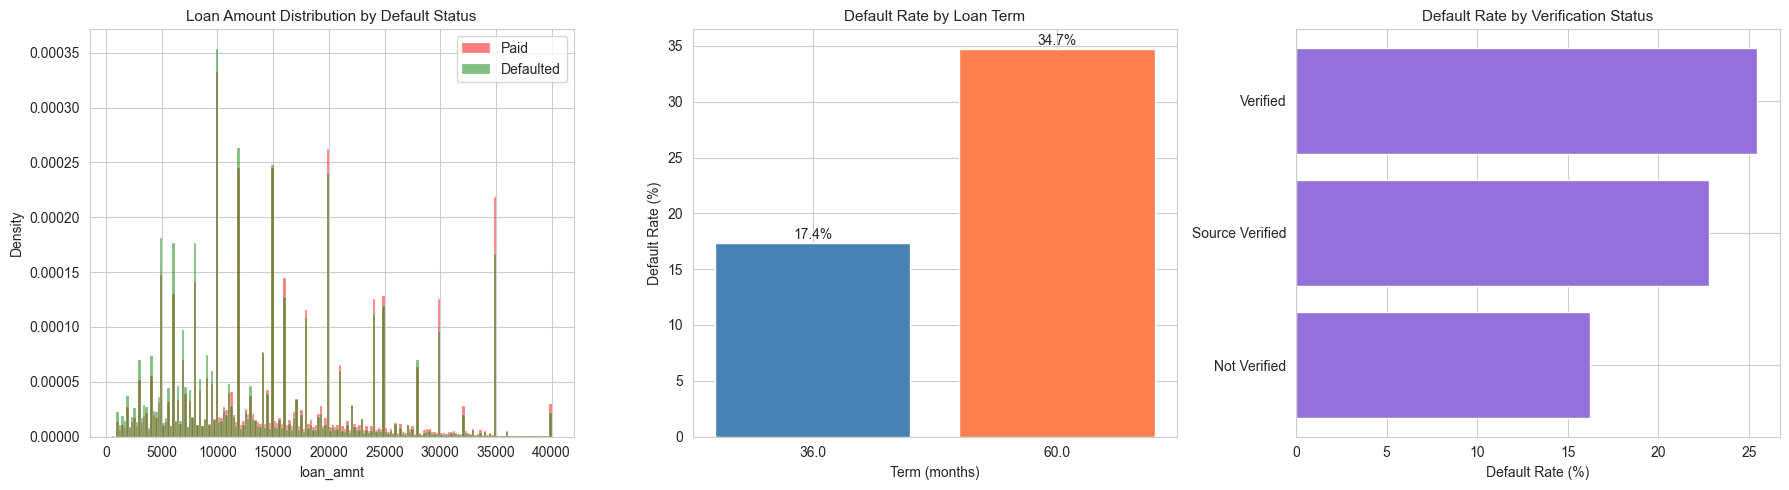

In [12]:
# ── 10. Loan Amount & Verification ──
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 10a. Loan amount distribution by default
if 'loan_amnt' in terminal.columns:
    sns.histplot(data=terminal, x='loan_amnt', hue='is_default', stat='density', 
                 common_norm=False, ax=axes[0], palette={0: 'green', 1: 'red'}, alpha=0.5)
    axes[0].set_title('Loan Amount Distribution by Default Status', fontsize=11)
    axes[0].legend(['Paid', 'Defaulted'])

# 10b. Term vs default
term_def = terminal.groupby('term')['is_default'].mean().reset_index()
axes[1].bar(term_def['term'].astype(str), term_def['is_default'] * 100, color=['steelblue', 'coral'])
axes[1].set_xlabel('Term (months)')
axes[1].set_ylabel('Default Rate (%)')
axes[1].set_title('Default Rate by Loan Term', fontsize=11)
for i, row in term_def.iterrows():
    axes[1].text(i, row['is_default'] * 100 + 0.3, f"{row['is_default']*100:.1f}%", ha='center')

# 10c. Verification status vs default
if 'verification_status' in terminal.columns:
    vs_def = terminal.groupby('verification_status')['is_default'].mean().sort_values().reset_index()
    axes[2].barh(vs_def['verification_status'], vs_def['is_default'] * 100, color='mediumpurple')
    axes[2].set_xlabel('Default Rate (%)')
    axes[2].set_title('Default Rate by Verification Status', fontsize=11)

plt.tight_layout()
plt.savefig(f'{CHARTS_DIR}/12_loan_amount_verification.png', dpi=150, bbox_inches='tight')
plt.show()

## 11. Correlation Heatmap of Key Numeric Features

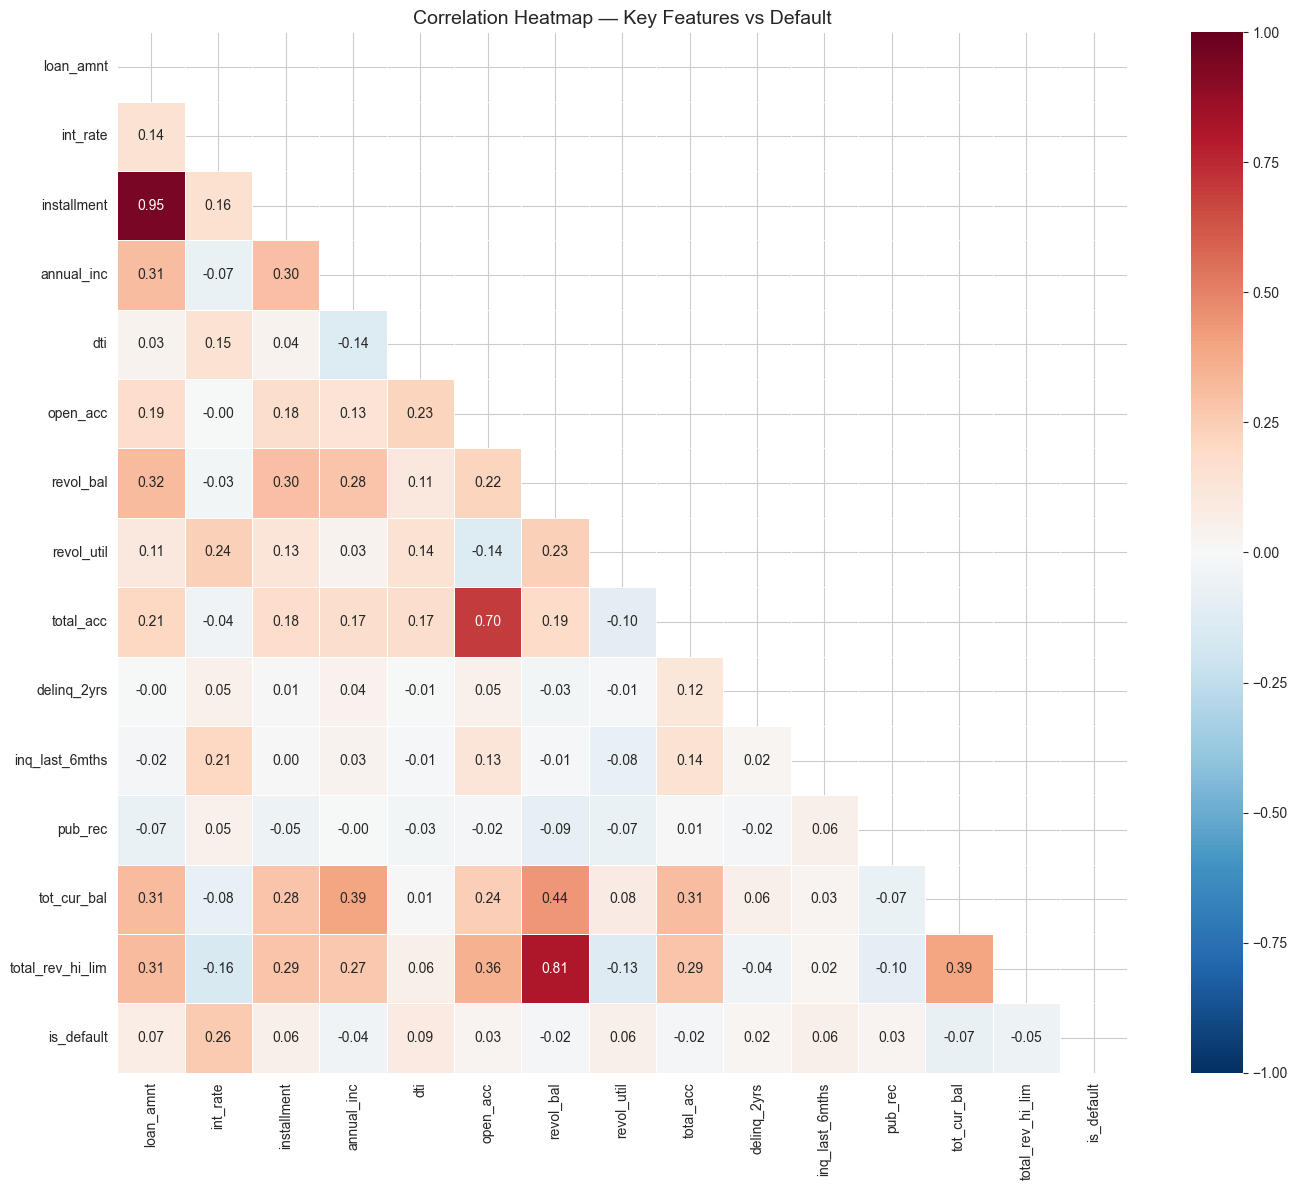

Top 10 features correlated with default:
int_rate           0.26
dti                0.09
loan_amnt          0.07
tot_cur_bal        0.07
inq_last_6mths     0.06
installment        0.06
revol_util         0.06
total_rev_hi_lim   0.05
annual_inc         0.04
open_acc           0.03


In [13]:
# ── 11. Correlation Heatmap ──
key_cols = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc',
            'revol_bal', 'revol_util', 'total_acc', 'delinq_2yrs', 'inq_last_6mths',
            'pub_rec', 'tot_cur_bal', 'total_rev_hi_lim', 'is_default']
avail_cols = [c for c in key_cols if c in terminal.columns]

corr_matrix = terminal[avail_cols].corr()

fig, ax = plt.subplots(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            ax=ax, linewidths=0.5, vmin=-1, vmax=1)
ax.set_title('Correlation Heatmap — Key Features vs Default', fontsize=14)
plt.tight_layout()
plt.savefig(f'{CHARTS_DIR}/13_correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

# Top correlations with is_default
default_corr = corr_matrix['is_default'].drop('is_default').abs().sort_values(ascending=False)
print("Top 10 features correlated with default:")
print(default_corr.head(10).to_string())

## 12. Recovery & Hardship Analysis

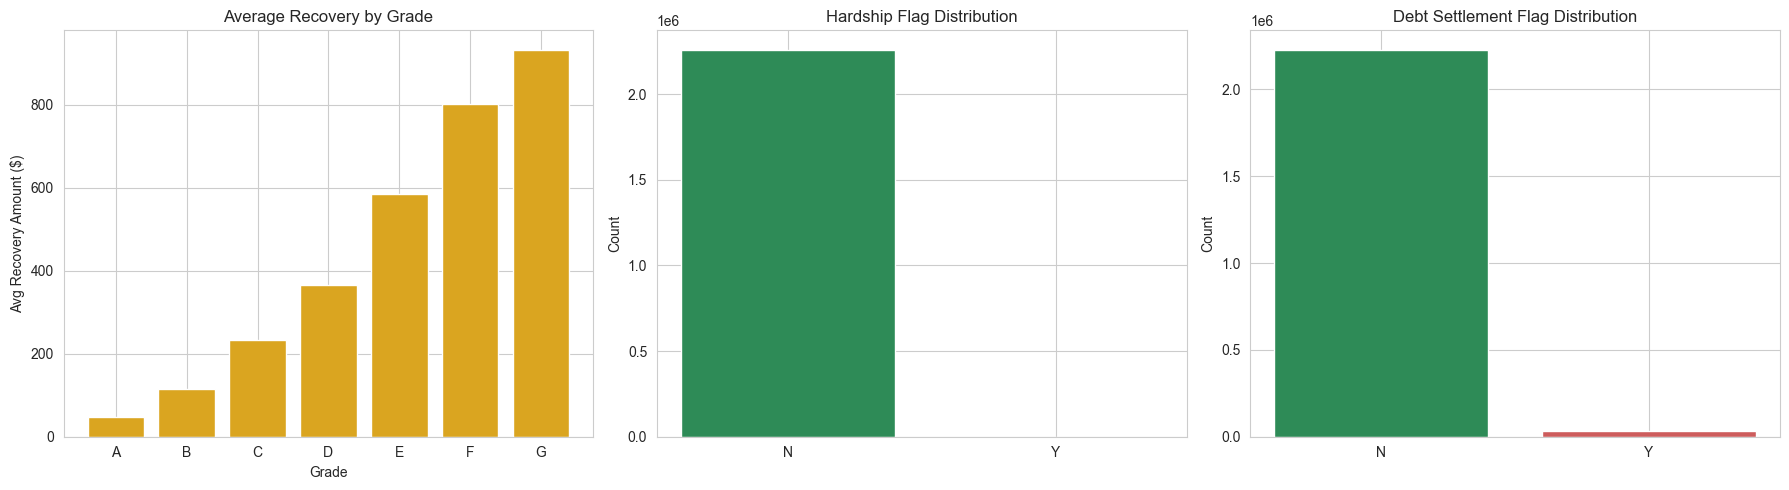

In [14]:
# ── 12. Recovery & Hardship/Settlement Patterns ──
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 12a. Recoveries by grade
if 'recoveries' in terminal.columns:
    rec_grade = terminal.groupby('grade')['recoveries'].mean().sort_index().reset_index()
    axes[0].bar(rec_grade['grade'], rec_grade['recoveries'], color='goldenrod')
    axes[0].set_xlabel('Grade')
    axes[0].set_ylabel('Avg Recovery Amount ($)')
    axes[0].set_title('Average Recovery by Grade', fontsize=12)

# 12b. Hardship flag distribution
if 'hardship_flag' in df.columns:
    hf = df['hardship_flag'].value_counts()
    axes[1].bar(hf.index, hf.values, color=['seagreen', 'indianred'])
    axes[1].set_title('Hardship Flag Distribution', fontsize=12)
    axes[1].set_ylabel('Count')

# 12c. Debt settlement flag distribution
if 'debt_settlement_flag' in df.columns:
    dsf = df['debt_settlement_flag'].value_counts()
    axes[2].bar(dsf.index, dsf.values, color=['seagreen', 'indianred'])
    axes[2].set_title('Debt Settlement Flag Distribution', fontsize=12)
    axes[2].set_ylabel('Count')

plt.tight_layout()
plt.savefig(f'{CHARTS_DIR}/14_recovery_hardship.png', dpi=150, bbox_inches='tight')
plt.show()

## 13. Summary of EDA Findings

Key findings answering the PDF's questions will be visible after running all cells above:
1. **Grade → Default**: Grade A–G should show monotonically increasing default rates
2. **Temporal Drift**: Check if grade lines cross over the years
3. **Interest Rate**: Higher grades get lower rates, but is the spread appropriate?
4. **DTI/Income**: Higher DTI → higher default; income relationship may not be linear
5. **Geographic**: State-level variation reveals hidden risk clusters
6. **Joint vs Individual**: Joint apps may show different default behavior
7. **Utilization**: High revolving utilization strongly predicts default
8. **Inquiries/Delinquencies**: Direct signals of financial stress

## Section 13 – State × Grade Default Heatmap (Q8 Deep-Dive)
Which states have the highest default rates, and how does that vary by loan grade?

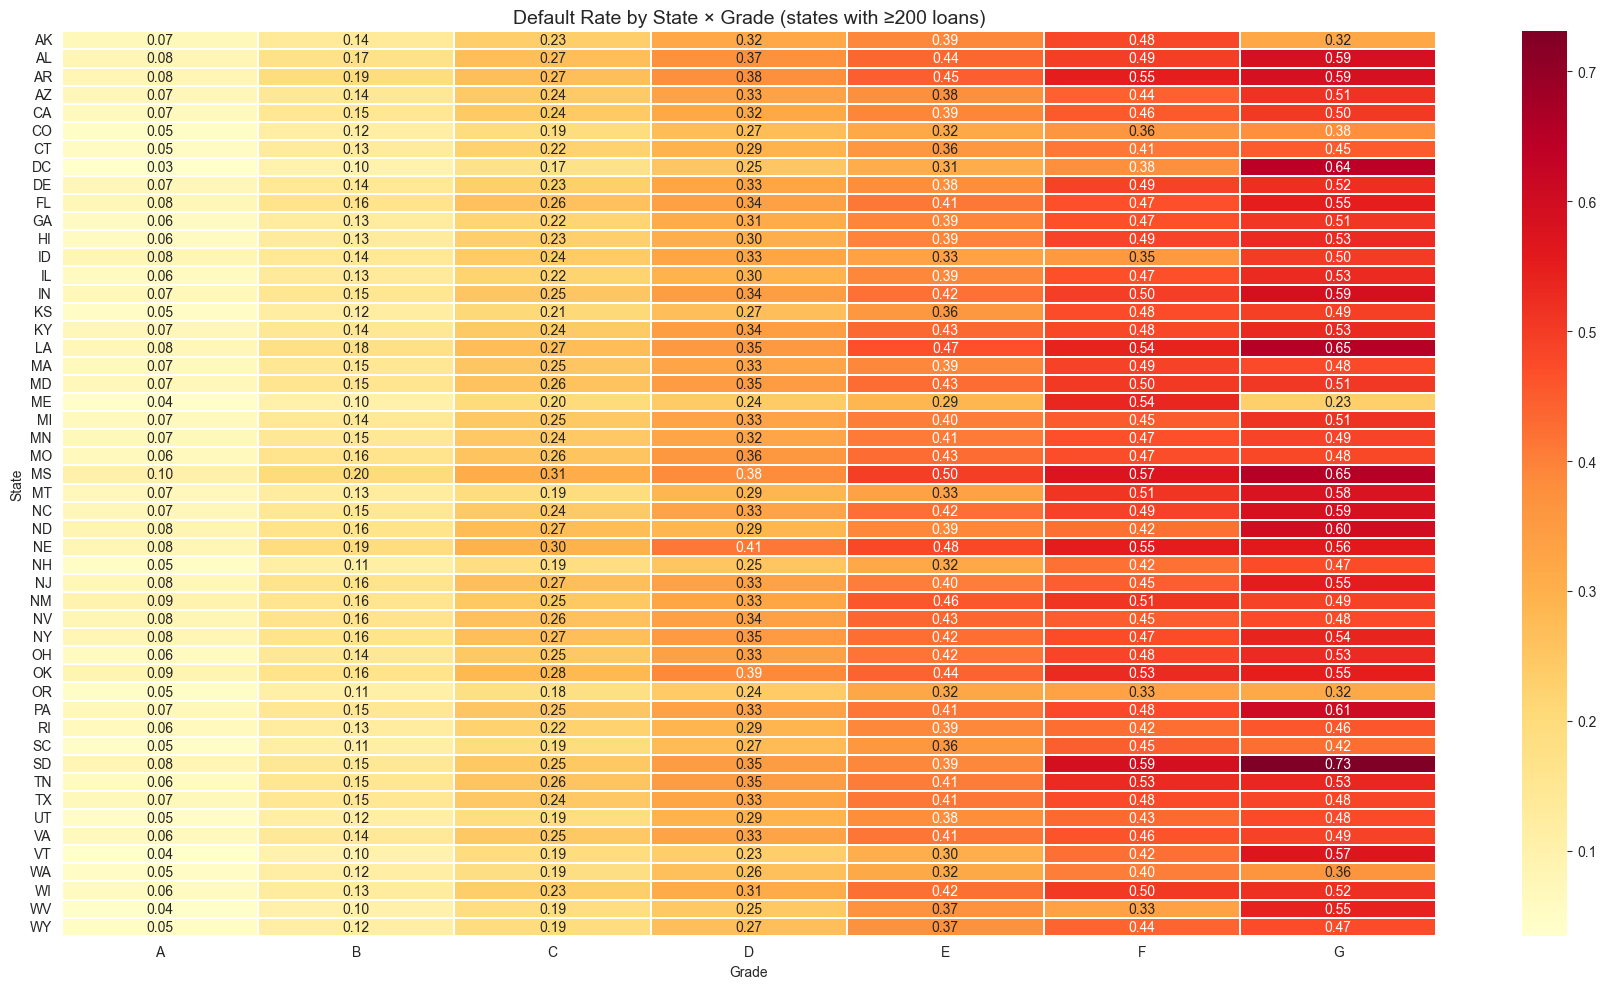

✅ Chart saved → ..\charts/23_state_grade_default_heatmap.png

Top-10 worst State×Grade combos (≥50 loans):
                  default_rate  n_loans
addr_state grade                       
MS         G              0.65       55
LA         G              0.65      109
PA         G              0.61      274
SD         F              0.59       54
IN         G              0.59      159
AL         G              0.59      136
AR         G              0.59       51
NC         G              0.59      285
MS         F              0.57      167
NJ         G              0.55      338


In [16]:
# ---------- Q8 Deep-Dive: State × Grade Default Heatmap ----------
import warnings, textwrap
warnings.filterwarnings('ignore')

# Keep only states with ≥200 loans for statistical reliability
state_counts = terminal['addr_state'].value_counts()
valid_states = state_counts[state_counts >= 200].index

sg = (terminal[terminal['addr_state'].isin(valid_states)]
      .groupby(['addr_state', 'grade'])['is_default']
      .mean().unstack(fill_value=0))

fig, ax = plt.subplots(figsize=(18, 10))
sns.heatmap(sg, annot=True, fmt='.2f', cmap='YlOrRd', linewidths=0.3, ax=ax)
ax.set_title('Default Rate by State × Grade (states with ≥200 loans)', fontsize=14)
ax.set_xlabel('Grade')
ax.set_ylabel('State')
plt.tight_layout()
fig.savefig(f'{CHARTS_DIR}/23_state_grade_default_heatmap.png', dpi=150)
plt.show()
print(f"✅ Chart saved → {CHARTS_DIR}/23_state_grade_default_heatmap.png")

# Highlight worst combos
worst = (terminal[terminal['addr_state'].isin(valid_states)]
         .groupby(['addr_state', 'grade'])['is_default']
         .agg(['mean', 'count'])
         .query('count >= 50')
         .sort_values('mean', ascending=False)
         .head(10))
worst.columns = ['default_rate', 'n_loans']
print("\nTop-10 worst State×Grade combos (≥50 loans):")
print(worst.to_string())

## Section 14 – Joint Application Financials (Q11 Deep-Dive)
How do joint borrowers' combined income, DTI, and default rates compare to individual applicants?

Available joint/income/dti columns: ['annual_inc', 'dti', 'dti_bin']

--- Financial Summary by Application Type ---
                 annual_inc                     dti              is_default            
                       mean   median      std  mean median   std       mean median  std
application_type                                                                       
Individual         76532.42 65000.00 70908.11 18.02  17.54  8.37       0.21   0.00 0.41
Joint App          57496.98 50000.00 39684.01 32.14  24.89 51.98       0.32   0.00 0.47


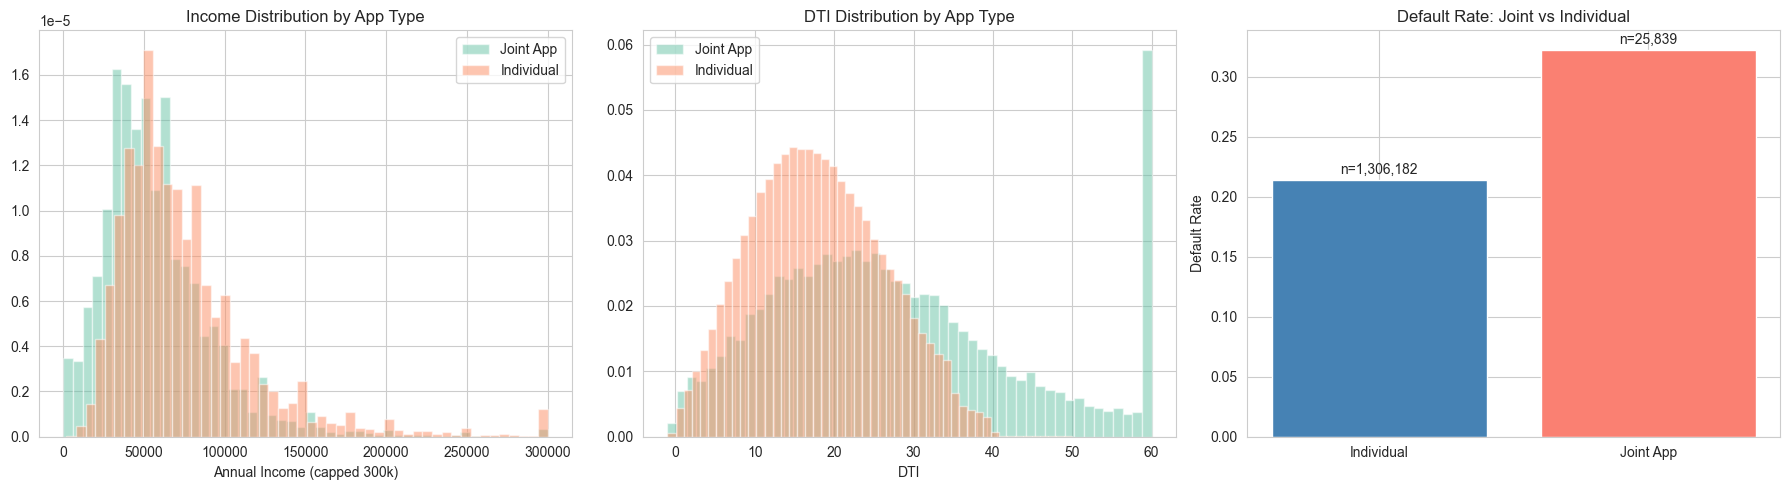


✅ Chart saved → ..\charts/24_joint_financials_comparison.png


In [17]:
# ---------- Q11 Deep-Dive: Joint vs Individual Financial Comparison ----------

# Identify joint-related income columns
joint_cols = [c for c in terminal.columns if 'joint' in c.lower() or 'annual_inc' in c.lower() or 'dti' in c.lower()]
print("Available joint/income/dti columns:", joint_cols)

# Compare key financial metrics by application type
fin_cols = ['annual_inc', 'dti', 'is_default']
# Add joint-specific cols if present
for c in ['annual_inc_joint', 'dti_joint']:
    if c in terminal.columns:
        fin_cols.append(c)

app_fin = terminal.groupby('application_type')[fin_cols].agg(['mean', 'median', 'std']).round(2)
print("\n--- Financial Summary by Application Type ---")
print(app_fin.to_string())

# Visualise
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1) Income distribution
for at in terminal['application_type'].dropna().unique():
    sub = terminal[terminal['application_type'] == at]['annual_inc'].clip(upper=300000)
    axes[0].hist(sub, bins=50, alpha=0.5, label=at, density=True)
axes[0].set_title('Income Distribution by App Type')
axes[0].set_xlabel('Annual Income (capped 300k)')
axes[0].legend()

# 2) DTI distribution
for at in terminal['application_type'].dropna().unique():
    sub = terminal[terminal['application_type'] == at]['dti'].dropna().clip(upper=60)
    axes[1].hist(sub, bins=50, alpha=0.5, label=at, density=True)
axes[1].set_title('DTI Distribution by App Type')
axes[1].set_xlabel('DTI')
axes[1].legend()

# 3) Default rate comparison with count labels
app_def = terminal.groupby('application_type').agg(
    default_rate=('is_default', 'mean'),
    n_loans=('is_default', 'count')
).reset_index()
bars = axes[2].bar(app_def['application_type'], app_def['default_rate'], color=['steelblue', 'salmon'])
for bar, n in zip(bars, app_def['n_loans']):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f'n={n:,}', ha='center', fontsize=10)
axes[2].set_title('Default Rate: Joint vs Individual')
axes[2].set_ylabel('Default Rate')

plt.tight_layout()
fig.savefig(f'{CHARTS_DIR}/24_joint_financials_comparison.png', dpi=150)
plt.show()
print(f"\n✅ Chart saved → {CHARTS_DIR}/24_joint_financials_comparison.png")

## Section 15 – Hardship & Settlement × Default (Q17 Deep-Dive)
Do borrowers who entered hardship plans or debt-settlement programs default at different rates? How does this vary by grade?

=== Hardship Flag × Default ===
is_default       0    1
hardship_flag          
N             0.78 0.22
Y             0.00 1.00

=== Debt Settlement Flag × Default ===
is_default              0    1
debt_settlement_flag          
N                    0.80 0.20
Y                    0.00 1.00


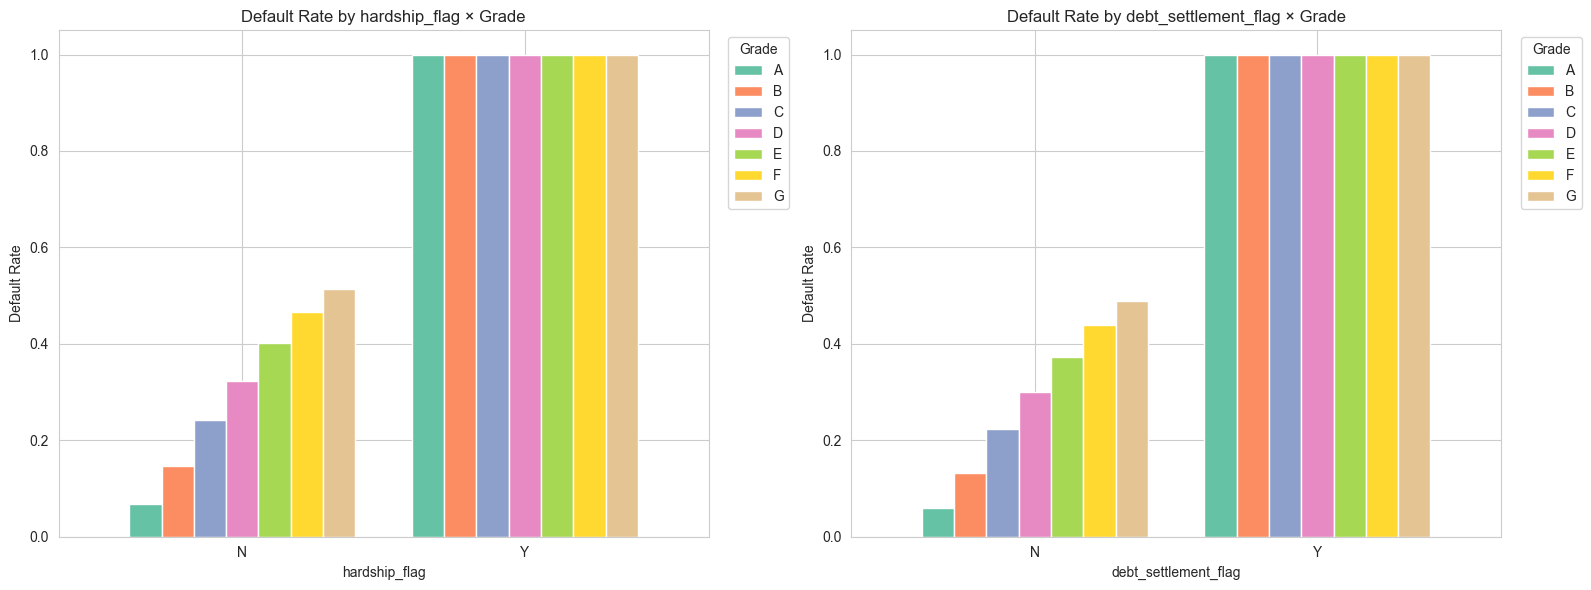


✅ Chart saved → ..\charts/25_hardship_settlement_vs_default.png

--- Hardship/Settlement Default Summary ---
                flag value  n_loans  default_rate
       hardship_flag     N  1331178          0.22
       hardship_flag     Y      843          1.00
debt_settlement_flag     N  1298996          0.20
debt_settlement_flag     Y    33025          1.00


In [18]:
# ---------- Q17 Deep-Dive: Hardship & Settlement vs Default ----------

# Convert flags to clean binary if needed
for flag in ['hardship_flag', 'debt_settlement_flag']:
    if flag in terminal.columns:
        terminal[flag] = terminal[flag].fillna('N').astype(str).str.strip().str.upper()

# --- Cross-tab: flag × default ---
print("=== Hardship Flag × Default ===")
if 'hardship_flag' in terminal.columns:
    ht = pd.crosstab(terminal['hardship_flag'], terminal['is_default'], normalize='index').round(4)
    print(ht)
else:
    print("Column not available")

print("\n=== Debt Settlement Flag × Default ===")
if 'debt_settlement_flag' in terminal.columns:
    dt = pd.crosstab(terminal['debt_settlement_flag'], terminal['is_default'], normalize='index').round(4)
    print(dt)
else:
    print("Column not available")

# --- Default rates by flag × grade ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, flag in enumerate(['hardship_flag', 'debt_settlement_flag']):
    if flag not in terminal.columns:
        axes[idx].text(0.5, 0.5, f'{flag} not in data', ha='center', va='center')
        continue
    pivot = (terminal.groupby([flag, 'grade'])['is_default']
             .mean().unstack(fill_value=0))
    pivot.plot(kind='bar', ax=axes[idx], width=0.8)
    axes[idx].set_title(f'Default Rate by {flag} × Grade', fontsize=12)
    axes[idx].set_ylabel('Default Rate')
    axes[idx].set_xlabel(flag)
    axes[idx].legend(title='Grade', bbox_to_anchor=(1.02, 1), loc='upper left')
    axes[idx].tick_params(axis='x', rotation=0)

plt.tight_layout()
fig.savefig(f'{CHARTS_DIR}/25_hardship_settlement_vs_default.png', dpi=150)
plt.show()
print(f"\n✅ Chart saved → {CHARTS_DIR}/25_hardship_settlement_vs_default.png")

# Summary table
summary_rows = []
for flag in ['hardship_flag', 'debt_settlement_flag']:
    if flag in terminal.columns:
        for val in terminal[flag].unique():
            sub = terminal[terminal[flag] == val]
            summary_rows.append({
                'flag': flag, 'value': val,
                'n_loans': len(sub),
                'default_rate': round(sub['is_default'].mean(), 4)
            })
summary_df = pd.DataFrame(summary_rows)
print("\n--- Hardship/Settlement Default Summary ---")
print(summary_df.to_string(index=False))